In [30]:
####### Import Necessary Libraries #######
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import math
from typing import Optional, Dict, Any, List, Tuple
from tqdm.auto import tqdm
import random


####### Data Loading && Preparation #######
import nltk 
nltk.download('punkt')
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, PreTrainedModel, PretrainedConfig
from transformers.modeling_outputs import SequenceClassifierOutput
# Use This for HF Dataset
from datasets import Dataset, DatasetDict

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from datetime import datetime

####### Modelling #######
import torch
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim


#######Evaluation & Result #######
from sklearn.metrics import classification_report, confusion_matrix,  accuracy_score, precision_recall_fscore_support, f1_score, ConfusionMatrixDisplay
import itertools


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KOMPUTER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

# Data Loading

In [4]:
BLOOM_DATASET = '../../Dataset/learning_outcomes.csv'
PAIR_DATASET = '../../Dataset/cpmk_subcpmk_pairs.csv'

In [5]:
bloom_df = pd.read_csv(BLOOM_DATASET)
pair_df = pd.read_csv(PAIR_DATASET)

print(bloom_df)
pair_df

                                       Learning_Outcome     Jenis Level
0     Mampu merencanakan, menyelesaikan, dan mengeva...      CPMK    C6
1     Mampu merencanakan, menyelesaikan, dan mengeva...      CPMK    C6
2     Mampu merencanakan, menyelesaikan, dan mengeva...      CPMK    C6
3                           Mampu merancang gardu induk      CPMK    C6
4                           Mampu merancang gardu induk      CPMK    C6
...                                                 ...       ...   ...
2571  Mahasiswa dapat memahami dan mempraktekkan iba...  Sub-CPMK    P3
2572  Mampu menunjukan pelaksanaan penegakan hukum &...  Sub-CPMK    A5
2573  Mahasiswa mampu menunjukkan implementasi nilai...  Sub-CPMK    A5
2574  Mampu bertindak mengimplementasikan makna Sila...  Sub-CPMK    A5
2575  Mampu bertindak mengimplementasikan Sila Ke-4 ...  Sub-CPMK    A5

[2576 rows x 3 columns]


,cpmk,level_cpmk,subcpmk,level_subcpmk,keselarasan
0,"Mampu merencanakan, menyelesaikan, dan mengeva...",C6,Merencanakan aplikasi menggunakan prinsip dasa...,C6,True
1,"Mampu merencanakan, menyelesaikan, dan mengeva...",C6,Menyelesaikan logic functions and gates,C2,True
2,"Mampu merencanakan, menyelesaikan, dan mengeva...",C6,Mengevaluasi boolean algebra dan combinational...,C5,True
3,Mampu merancang gardu induk,C6,Mampu merancang instalasi listrik gardu induk,C6,True
4,Mampu merancang gardu induk,C6,Mampu merancang sistem pengetanahan gardu induk,C6,True
...,...,...,...,...,...
1283,"Mahasiswa mampu mempraktekkan haji, umroh dan ...",P3,Mahasiswa dapat memahami dan mempraktekkan iba...,P3,True
1284,"Mampu menganalisis masalah kontekstual PKn, me...",C4,Mampu menunjukan pelaksanaan penegakan hukum &...,A5,False
1285,Mahasiswa mampu menafsirkan dan menerapkan nil...,C3,Mahasiswa mampu menunjukkan implementasi nilai...,A5,False
1286,"Mampu menunjukan nilai ketuhanan, nilai kemanu...",A5,Mampu bertindak mengimplementasikan makna Sila...,A5,True


# Data Preparation & Modelling - Bloom

## Data Preparation

In [6]:
# Basic checks & cleaning
required_cols = ["Learning_Outcome", "Level"]
if not all(c in bloom_df.columns for c in required_cols):
    raise ValueError(f"CSV must contain columns: {required_cols}. Found: {list(bloom_df.columns)}")

bloom_df = bloom_df.dropna(subset=["Learning_Outcome", "Level"]).reset_index(drop=True)
bloom_df["Learning_Outcome"] = bloom_df["Learning_Outcome"].astype(str).str.strip()
bloom_df["Level"] = bloom_df["Level"].astype(str).str.strip().str.upper()

In [7]:
# Create label mapping
labels = sorted(bloom_df["Level"].unique().tolist(), key=lambda x: (x[0], int(x[1:]) if x[1:].isdigit() else x))
label2id = {lab:i for i, lab in enumerate(labels)}
id2label = {i:lab for lab,i in label2id.items()}

bloom_df["label_id"] = bloom_df["Level"].map(label2id)

In [8]:
# Train / val split (stratify by label)
train_df, val_df = train_test_split(bloom_df, test_size=0.2, random_state=42, stratify=bloom_df["label_id"])
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))
datasets = DatasetDict({"train": train_ds, "validation": val_ds})


## Modelling 

### Preparation

In [9]:
INDO_BERT_BASE = "indobenchmark/indobert-base-p2"   


In [10]:
OUTPUT_DIR = "Classification-result/indobert_base_single_head_out_optimized"
SEED = 42 
BATCH_SIZE = 16
EPOCHS = 5
LR = 2e-5
MAX_LEN = 512

In [ ]:
MODEL_NAME = INDO_BERT_BASE

# Tokenizer and preprocessing

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [12]:

# Model
num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(INDO_BERT_BASE , num_labels=num_labels, use_safetensors=True)
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
def preprocess_fn(batch):
    enc = tokenizer(batch["Learning_Outcome"], truncation=True, padding="max_length", max_length=MAX_LEN)
    enc["labels"] = batch["label_id"]
    return enc

### Zero-Shot Learning

In [111]:
bloom_ds = Dataset.from_pandas(
    bloom_df.reset_index(drop=True)
)

bloom_ds = bloom_ds.map(
    preprocess_fn,
    batched=True,
    remove_columns=bloom_ds.column_names
)

bloom_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

Map:   0%|          | 0/2576 [00:00<?, ? examples/s]

In [112]:
loader = DataLoader(
    bloom_ds,
    batch_size=16,
    shuffle=False
)

In [113]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(loader, desc="Evaluating IndoBERT (no_grad)"):
        inputs = {
            "input_ids": batch["input_ids"].to(model.device),
            "attention_mask": batch["attention_mask"].to(model.device),
        }
        labels = batch["labels"].to(model.device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Evaluating IndoBERT (no_grad):   0%|          | 0/161 [00:00<?, ?it/s]

In [114]:
decoded_preds = [id2label[int(i)] for i in all_preds]
decoded_labels = [id2label[int(i)] for i in all_labels]

print(classification_report(decoded_labels, decoded_preds))

              precision    recall  f1-score   support

          A2       0.00      0.00      0.00         3
          A3       0.00      0.00      0.00         5
          A4       0.00      0.00      0.00        78
          A5       0.00      0.00      0.00        77
          C1       0.00      0.00      0.00        87
          C2       0.20      0.00      0.00       491
          C3       0.10      0.34      0.15       292
          C4       0.00      0.00      0.00       488
          C5       0.00      0.00      0.00       211
          C6       0.00      0.00      0.00       466
          P2       0.02      0.83      0.03        29
          P3       0.00      0.00      0.00       224
          P4       0.00      0.00      0.00       103
          P5       0.00      0.00      0.00        22

    accuracy                           0.05      2576
   macro avg       0.02      0.08      0.01      2576
weighted avg       0.05      0.05      0.02      2576



C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

### Single Head

#### Fine-Tune

In [ ]:
datasets = datasets.map(preprocess_fn, batched=True, remove_columns=datasets["train"].column_names)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/2060 [00:00<?, ? examples/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

In [116]:
def compute_metrics(eval_pred):
    preds_logits, labels = eval_pred
    preds = np.argmax(preds_logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
    

In [117]:

# Training args
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_steps=50,
    seed=SEED,
    fp16= True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
)



In [118]:
import accelerate
print(accelerate.__version__)
print(accelerate.__file__)

1.12.0
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\accelerate\__init__.py


In [119]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\KOMPUTER\AppData\Local\Temp\ipykernel_7304\1674331945.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [120]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.406800,0.881233,0.757752,0.720809,0.757752,0.729302
2,0.688900,0.701295,0.800388,0.783078,0.800388,0.781357
3,0.452900,0.658745,0.808140,0.796496,0.808140,0.793938
4,0.306500,0.639371,0.819767,0.808944,0.819767,0.808438
5,0.221700,0.619829,0.823643,0.809148,0.823643,0.812033


TrainOutput(global_step=645, training_loss=0.6153615581896879, metrics={'train_runtime': 345.833, 'train_samples_per_second': 29.783, 'train_steps_per_second': 1.865, 'total_flos': 2710335858892800.0, 'train_loss': 0.6153615581896879, 'epoch': 5.0})

In [122]:
import os

# Eval final
metrics = trainer.evaluate()
print("Final evaluation metrics:", metrics)

Final evaluation metrics: {'eval_loss': 0.6198291182518005, 'eval_accuracy': 0.8236434108527132, 'eval_precision': 0.809148103049377, 'eval_recall': 0.8236434108527132, 'eval_f1': 0.8120325095893367, 'eval_runtime': 4.4292, 'eval_samples_per_second': 116.501, 'eval_steps_per_second': 7.451, 'epoch': 5.0}


#### Eval-Bloom Accuracy

Val Set

In [123]:
def preprocess(ex):
    return tokenizer(
        ex["Learning_Outcome"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

val_tokenized = val_ds.map(preprocess, batched=True)
val_tokenized = val_tokenized.rename_column("label_id", "labels")

from torch.utils.data import DataLoader

def collate_fn(batch):
    return {
        "input_ids": torch.tensor([x["input_ids"] for x in batch]),
        "attention_mask": torch.tensor([x["attention_mask"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch]),
    }

loader = DataLoader(val_tokenized, batch_size=16, shuffle=False, collate_fn=collate_fn)

all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(loader):
        inputs = {
            "input_ids": batch["input_ids"].to(model.device),
            "attention_mask": batch["attention_mask"].to(model.device)
        }
        labels = batch["labels"].to(model.device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

decoded_preds = [id2label[i] for i in all_predictions]
decoded_labels = [id2label[i] for i in all_labels]


print(classification_report(decoded_labels, decoded_preds))



Map:   0%|          | 0/516 [00:00<?, ? examples/s]

  0%|          | 0/33 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          A2       0.00      0.00      0.00         1
          A3       0.00      0.00      0.00         1
          A4       0.50      0.19      0.27        16
          A5       0.52      0.80      0.63        15
          C1       0.89      0.94      0.91        17
          C2       0.88      0.90      0.89        98
          C3       0.77      0.75      0.76        59
          C4       0.84      0.88      0.86        98
          C5       0.86      0.86      0.86        42
          C6       0.94      0.98      0.96        93
          P2       0.50      0.17      0.25         6
          P3       0.69      0.76      0.72        45
          P4       0.70      0.67      0.68        21
          P5       0.00      0.00      0.00         4

    accuracy                           0.82       516
   macro avg       0.58      0.56      0.56       516
weighted avg       0.81      0.82      0.81       516



C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

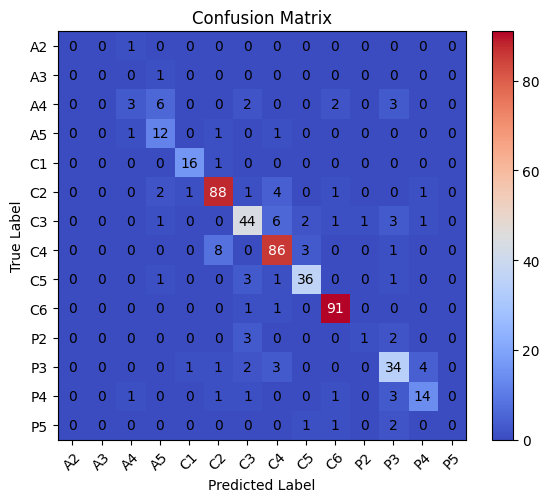

In [124]:
labels = sorted(list(set(decoded_labels)))


cm = confusion_matrix(
    decoded_labels,
    decoded_preds,
    labels=labels
)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="coolwarm")
plt.colorbar()

plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

threshold = cm.max() / 2
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(
            j, i, cm[i, j],
            ha="center",
            va="center",
            color="white" if cm[i, j] > threshold else "black"
        )

plt.tight_layout()
plt.show()



Train Set

In [125]:
train_tokenized = train_ds.map(preprocess, batched=True)
train_tokenized = train_tokenized.rename_column("label_id", "labels")

from torch.utils.data import DataLoader

def collate_fn(batch):
    return {
        "input_ids": torch.tensor([x["input_ids"] for x in batch]),
        "attention_mask": torch.tensor([x["attention_mask"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch]),
    }

loader = DataLoader(train_tokenized, batch_size=16, shuffle=False, collate_fn=collate_fn)

all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(loader):
        inputs = {
            "input_ids": batch["input_ids"].to(model.device),
            "attention_mask": batch["attention_mask"].to(model.device)
        }
        labels = batch["labels"].to(model.device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

decoded_preds = [id2label[i] for i in all_predictions]
decoded_labels = [id2label[i] for i in all_labels]


print(classification_report(decoded_labels, decoded_preds))

Map:   0%|          | 0/2060 [00:00<?, ? examples/s]

  0%|          | 0/129 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          A2       0.00      0.00      0.00         2
          A3       0.00      0.00      0.00         4
          A4       0.96      0.85      0.91        62
          A5       0.88      0.94      0.91        62
          C1       0.97      0.96      0.96        70
          C2       0.98      0.98      0.98       393
          C3       0.95      0.97      0.96       233
          C4       0.97      0.98      0.98       390
          C5       0.98      0.98      0.98       169
          C6       0.97      0.99      0.98       373
          P2       1.00      0.52      0.69        23
          P3       0.89      0.98      0.94       179
          P4       0.94      0.94      0.94        82
          P5       1.00      0.11      0.20        18

    accuracy                           0.96      2060
   macro avg       0.82      0.73      0.74      2060
weighted avg       0.96      0.96      0.95      2060



C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KOMPUTER\anaconda3\envs\fadfad\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

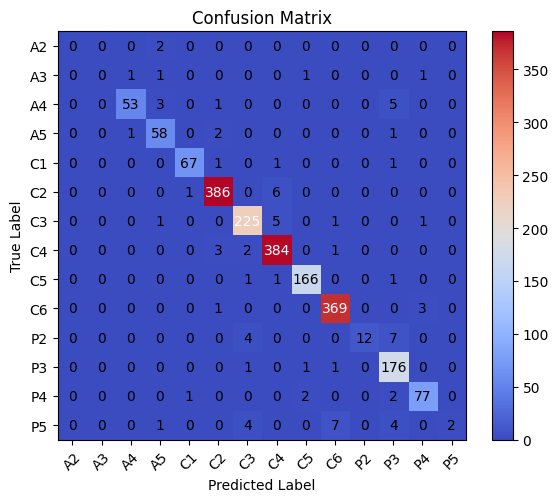

In [126]:
labels = sorted(list(set(decoded_labels)))


cm = confusion_matrix(
    decoded_labels,
    decoded_preds,
    labels=labels
)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="coolwarm")
plt.colorbar()

plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

threshold = cm.max() / 2
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(
            j, i, cm[i, j],
            ha="center",
            va="center",
            color="white" if cm[i, j] > threshold else "black"
        )

plt.tight_layout()
plt.show()



#### Save

In [128]:
# Save model, tokenizer, and label maps
os.makedirs(OUTPUT_DIR, exist_ok=True)
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
pd.to_pickle(label2id, os.path.join(OUTPUT_DIR, "label2id.pkl"))
pd.to_pickle(id2label, os.path.join(OUTPUT_DIR, "id2label.pkl"))
print("Model & tokenizer saved to", OUTPUT_DIR)

Model & tokenizer saved to Classification-result/indobert_base_single_head_out_optimized


#### Eval-Alignment Accuracy

In [129]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification


MODEL_DIR = "Classification-result/indobert_base_single_head_out"   # tempat model & tokenizer disimpan
BATCH_SIZE = 16
MAX_LEN = 128
# nama kolom di dataframe
CPMK_COL = "cpmk"
SUBCPMK_COL = "subcpmk"
GOLD_KES_COL = "keselarasan" 

In [ ]:
def predict_texts(texts, batch_size=BATCH_SIZE):
    preds = []
    n = len(texts)
    for i in tqdm(range(0, n, batch_size), desc="Predicting", leave=False):
        batch_texts = [str(t) if t is not None else "" for t in texts[i:i+batch_size]]
        enc = tokenizer(batch_texts, padding="longest", truncation=True, max_length=MAX_LEN, return_tensors="pt")
        enc = {k:v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=-1).cpu().numpy().tolist()
            preds.extend(batch_preds)
    return preds

def decode_ids_to_labels(id_list):
    return [id2label.get(int(i), "UNK") for i in id_list]


def pred_selaras_separated(row):
    dom_c, lvl_c = row["pred_domain_cpmk"], row["pred_level_cpmk"]
    dom_s, lvl_s = row["pred_domain_sub"], row["pred_level_sub"]
    

    if dom_c is None or dom_s is None or lvl_c is None or lvl_s is None:
        return "Tidak Selaras"
    

    if dom_c != dom_s:
        return "Tidak Selaras"
    if lvl_c < lvl_s:
        return "Tidak Selaras"
    return "Selaras"    

def pred_selaras(row):
    c = row["pred_label_cpmk"]
    s = row["pred_label_subcpmk"]

 
    if not isinstance(c, str) or not isinstance(s, str):
        return "False"

   
    if len(c) < 2 or len(s) < 2:
        return "False"

  
    dom_c, lvl_c = c[0], c[1:]
    dom_s, lvl_s = s[0], s[1:]

   
    if not lvl_c.isdigit() or not lvl_s.isdigit():
        return "False"

    lvl_c = int(lvl_c)
    lvl_s = int(lvl_s)

 
    if dom_c != dom_s:
        return "False"

    if lvl_c < lvl_s:
        return "False"

    return "True"
  

In [ ]:
from transformers import AutoModelForSequenceClassification


config = AutoConfig.from_pretrained(MODEL_DIR, local_files_only=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR,
    local_files_only=True,
    config=config
)

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:
df = pair_df

df[CPMK_COL] = df[CPMK_COL].fillna("").astype(str)
df[SUBCPMK_COL] = df[SUBCPMK_COL].fillna("").astype(str)


pred_ids_cpmk = predict_texts(df[CPMK_COL].tolist(), batch_size=BATCH_SIZE)
pred_ids_sub = predict_texts(df[SUBCPMK_COL].tolist(), batch_size=BATCH_SIZE)


pred_labels_cpmk = decode_ids_to_labels(pred_ids_cpmk)
pred_labels_sub = decode_ids_to_labels(pred_ids_sub)



Predicting:   0%|          | 0/81 [00:00<?, ?it/s]

Predicting:   0%|          | 0/81 [00:00<?, ?it/s]

In [133]:
df = df.copy()
df["pred_label_cpmk"] = pred_labels_cpmk
df["pred_label_subcpmk"] = pred_labels_sub


df["pred_keselarasan"] = df.apply(pred_selaras, axis=1)

In [134]:
def plot_confusion_matrix(
    y_true,
    y_pred,
    labels,
    title="Confusion Matrix",
    normalize=False,
    cmap="coolwarm",
    figsize=(5, 4)
):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)

    plt.figure(figsize=figsize)
    plt.imshow(cm, cmap=cmap)
    plt.colorbar()

    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)

    threshold = cm.max() / 2
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = f"{cm[i, j]:.2f}" if normalize else f"{int(cm[i, j])}"
            plt.text(
                j, i, text,
                ha="center",
                va="center",
                color="white" if cm[i, j] > threshold else "black"
            )

    plt.tight_layout()
    plt.show()


Keselarasan evaluation:
              precision    recall  f1-score   support

       False       0.91      0.91      0.91       410
        True       0.96      0.96      0.96       878

    accuracy                           0.94      1288
   macro avg       0.93      0.93      0.93      1288
weighted avg       0.94      0.94      0.94      1288

Accuracy: 0.9402173913043478


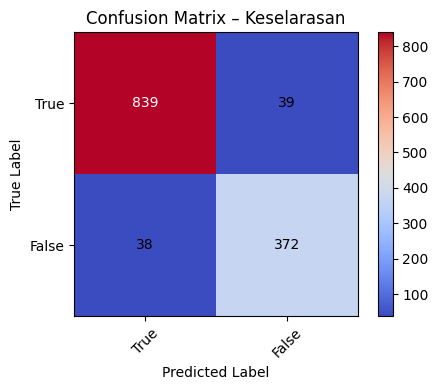

,cpmk,pred_label_cpmk,subcpmk,pred_label_subcpmk,pred_keselarasan
1120,Mahasiswa mampu mempraktikan dan analisis terh...,C4,Mahasiswa mampu mengidentifikasi profil tanah...,C1,True
1185,Mahasiswa mampu mempraktikkan proses rekrutmen...,P3,Mahasiswa melakukan evaluasi terhadap proses s...,C5,False
462,Mampu menyajikan serta mengolah data secara il...,C3,Mampu mengolah data secara ilmiah,C3,True
81,Mahasiswa mampu melakukan analisis gender dan ...,C4,Mahasiswa mampu menjelaskan langkah analisis p...,C2,True
63,Mahasiswa mampu menerapkan konsep dasar biosta...,C3,"mahasiswa mampu menyebutkan jenis-jenis data, ...",C1,True
123,Mahasiwa mampu memahami Analisis Spasial Mengg...,C2,Mahasiswa mampu menjelaskan aplikasi SatScan d...,C2,True
451,Mahasiswa mampu mendeskripsikan struktur dan s...,C2,Mahasiswa mampu mendeskripsikan struktur dan s...,C2,True
1042,Mahasiswa mampu menyusun identitas awal perusa...,C3,Mahasiswa mampu membuat nomor dan nama rekenin...,C3,True
723,Mahasiswa mampu menyelesaikan prosedur akuntan...,C3,Mahasiswa mampu menyelesaikan prosedur akuntan...,C3,True
44,Mahasiswa mampu memahami gagasan utama dari pe...,C2,Mampu memahami gagasan utama dan informasi det...,C2,True


In [135]:
if "level_cpmk" in df.columns and "level_subcpmk" in df.columns:
        # convert true columns to same format as model (e.g. 'C3')
    true_labels_cpmk = df["level_cpmk"].astype(str).str.upper().tolist()
    true_labels_sub = df["level_subcpmk"].astype(str).str.upper().tolist()

if GOLD_KES_COL in df.columns:
    gold = df[GOLD_KES_COL].astype(str).str.strip().replace({"SELARAS":"Selaras","TIDAK SELARAS":"Tidak Selaras"})
    pred = df["pred_keselarasan"]
    print("Keselarasan evaluation:")
    print(classification_report(gold, pred, zero_division=0))
    print("Accuracy:", accuracy_score(gold, pred))
    
    plot_confusion_matrix(
        gold,
        pred,
        labels=["True", "False"],
        title="Confusion Matrix – Keselarasan",
        normalize=False
    )
else:
    print(f"No gold keselarasan column named '{GOLD_KES_COL}' found — created predictions only.")


display(df[[CPMK_COL, "pred_label_cpmk", SUBCPMK_COL, "pred_label_subcpmk", "pred_keselarasan"]].sample(10, random_state=42))

# Data Preparation & Modelling - Siamese

## Data Loading

In [41]:
#Use This for Custom Model
from torch.utils.data import Dataset, DataLoader

In [42]:
def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    needed = ["cpmk", "subcpmk", "keselarasan"]
    for c in needed:
        if c not in df.columns:
            raise ValueError(f"Kolom '{c}' tidak ditemukan di df.")
    df["cpmk"] = df["cpmk"].fillna("").astype(str)
    df["subcpmk"] = df["subcpmk"].fillna("").astype(str)
    def norm_kes(x):
        s = str(x).strip().lower()
        if s in ["selaras", "1", "true", "ya", "yes", "True"]:
            return 1
        return 0
    df["label"] = df["keselarasan"].apply(norm_kes)
    df = df[(df["cpmk"].str.strip() != "") | (df["subcpmk"].str.strip() != "")]
    df = df.reset_index(drop=True)
    return df[["cpmk", "subcpmk", "label"]]

## Data Preparation

In [43]:
OUTPUT_DIR =   "Classification-result/indobert-siamese"
SEED = 42
BATCH_SIZE = 16
EPOCHS = 20
LR = 2e-5
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

In [44]:
class PairTextDataset(Dataset):
    def __init__(self, texts_a: List[str], texts_b: List[str], labels: List[int], tokenizer: AutoTokenizer, max_len=128):
        self.texts_a = texts_a
        self.texts_b = texts_b
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        a = str(self.texts_a[idx])
        b = str(self.texts_b[idx])
        la = self.tokenizer(a, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        lb = self.tokenizer(b, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        item = {
            "input_ids_a": la["input_ids"].squeeze(0),
            "attention_mask_a": la["attention_mask"].squeeze(0),
            "input_ids_b": lb["input_ids"].squeeze(0),
            "attention_mask_b": lb["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

In [45]:
def collate_fn(batch):
    # batch: list of items returned by __getitem__
    input_ids_a = torch.stack([b["input_ids_a"] for b in batch], dim=0)
    attention_mask_a = torch.stack([b["attention_mask_a"] for b in batch], dim=0)
    input_ids_b = torch.stack([b["input_ids_b"] for b in batch], dim=0)
    attention_mask_b = torch.stack([b["attention_mask_b"] for b in batch], dim=0)
    labels = torch.stack([b["label"] for b in batch], dim=0)
    return {
        "input_ids_a": input_ids_a,
        "attention_mask_a": attention_mask_a,
        "input_ids_b": input_ids_b,
        "attention_mask_b": attention_mask_b,
        "labels": labels
    }

## Siamese modeling

In [46]:
class SiameseIndoBert(nn.Module):
    def __init__(self, model_name: str, dropout=0.1, hidden_dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(
            model_name,
            use_safetensors=True,
            output_hidden_states=False
        )
        hs = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        # classifier: take concatenation [hA, hB, |hA-hB|, hA*hB]
        self.classifier = nn.Sequential(
            nn.Linear(hs * 4, hs),
            nn.ReLU(),
            nn.Dropout(hidden_dropout),
            nn.Linear(hs, 1)   # output logits for binary
        )

    def encode(self, input_ids, attention_mask):
        # return pooled CLS embedding
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            pooled = out.pooler_output
        elif hasattr(out, "last_hidden_state"):
            pooled = out.last_hidden_state[:, 0, :]
        else:
            # fallback: hidden_states[-1][:,0,:] if available
            if hasattr(out, "hidden_states") and out.hidden_states:
                pooled = out.hidden_states[-1][:,0,:]
            else:
                raise ValueError("Encoder output has no pooler_output/last_hidden_state/hidden_states")
        return pooled

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b):
        hA = self.encode(input_ids_a, attention_mask_a)   # (bs, hs)
        hB = self.encode(input_ids_b, attention_mask_b)
        diff = torch.abs(hA - hB)
        mul = hA * hB
        feat = torch.cat([hA, hB, diff, mul], dim=-1)
        feat = self.dropout(feat)
        logits = self.classifier(feat).squeeze(-1)   # (bs,)
        return logits


In [47]:
class SiameseTrainer:
    def __init__(self, model: nn.Module, train_loader: DataLoader, val_loader: DataLoader = None,
                 lr=2e-5, epochs=3, device=None, weight_decay=0.01, warmup_steps=0):
        self.model = model.to(DEVICE if device is None else device)
        self.epochs = epochs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        total_steps = len(train_loader) * epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
        self.device = DEVICE if device is None else device

    def train_epoch(self, epoch_idx: int = 0):
        self.model.train()
        total_loss = 0.0
        n_batches = 0
    
        # === TAMBAHAN: penampung prediksi ===
        all_preds = []
        all_labels = []
    
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch_idx+1}/{self.epochs} - Train", leave=True)
        for batch in pbar:
            self.optimizer.zero_grad()
    
            inputs = {k: v.to(self.device) for k,v in batch.items() if k != "labels"}
            labels = batch["labels"].to(self.device).float()
    
            logits = self.model(**inputs)
            loss = self.criterion(logits, labels)
    
            loss.backward()
            self.optimizer.step()
    
            # step scheduler after optimizer.step() (HF-style)
            if self.scheduler is not None:
                self.scheduler.step()
    
            total_loss += loss.item()
            n_batches += 1
    
            # === HITUNG PREDIKSI (BINARY) ===
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()
    
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    
            try:
                curr_lr = self.optimizer.param_groups[0]['lr']
            except:
                curr_lr = None
    
            pbar.set_postfix({
                "loss": f"{(total_loss / n_batches):.4f}",
                "lr": f"{curr_lr:.2e}" if curr_lr is not None else "N/A"
            })
    
        avg_loss = total_loss / max(1, n_batches)
    
        # === TRAIN METRICS ===
        train_acc = accuracy_score(all_labels, all_preds)
        train_f1  = f1_score(all_labels, all_preds)
    
        pbar.close()
    
        return {
            "loss": avg_loss,
            "accuracy": train_acc,
            "f1": train_f1
        }


    def evaluate(self):
        if self.val_loader is None:
            return None
        self.model.eval()
        all_preds = []
        all_labels = []

        pbar = tqdm(self.val_loader, desc="Validation", leave=True)
        with torch.no_grad():
            for batch in pbar:
                inputs = {k: v.to(self.device) for k,v in batch.items() if k != "labels"}
                labels = batch["labels"].to(self.device).float()
                logits = self.model(**inputs)
                probs = torch.sigmoid(logits).cpu().numpy()
                preds = (probs >= 0.5).astype(int)
                all_preds.extend(preds.tolist())
                all_labels.extend(labels.cpu().numpy().astype(int).tolist())

                # optionally show interim accuracy on the progressbar
                if len(all_labels) > 0:
                    interim_acc = accuracy_score(all_labels, all_preds)
                    pbar.set_postfix({"interim_acc": f"{interim_acc:.4f}"})

        pbar.close()

        report = classification_report(all_labels, all_preds, zero_division=0)
        acc = accuracy_score(all_labels, all_preds)
        try:
            auc = roc_auc_score(all_labels, [float(p) for p in all_preds])
        except:
            auc = None
        return {"report": report, "accuracy": acc, "auc": auc}

    def fit(self):
        best_acc = -1.0
    
        for epoch in range(self.epochs):
            train_metrics = self.train_epoch(epoch_idx=epoch)
    
            print(
                f"Epoch {epoch+1}/{self.epochs} | "
                f"Train Loss: {train_metrics['loss']:.4f} | "
                f"Train Acc: {train_metrics['accuracy']:.4f} | "
                f"Train F1: {train_metrics['f1']:.4f}"
            )
    
            val_stats = self.evaluate()
            if val_stats:
                print("Validation accuracy:", val_stats["accuracy"])
                print(val_stats["report"])
    
                # save best by validation accuracy
                if val_stats["accuracy"] > best_acc:
                    best_acc = val_stats["accuracy"]
                    self.save(os.path.join(OUTPUT_DIR, "best_model"))
                    print("Saved best model.")
    
        return


    def predict_pairs(self, pairs: List[Tuple[str,str]], tokenizer: AutoTokenizer, batch_size=16):
        self.model.eval()
        texts_a = [a for a,b in pairs]
        texts_b = [b for a,b in pairs]
        ds = PairTextDataset(texts_a, texts_b, [0]*len(pairs), tokenizer, max_len=MAX_LEN)
        loader = DataLoader(ds, batch_size=batch_size, collate_fn=collate_fn)
        all_probs = []

        pbar = tqdm(loader, desc="Predicting pairs", leave=True)
        with torch.no_grad():
            for batch in pbar:
                inputs = {k: v.to(self.device) for k,v in batch.items() if k != "labels"}
                logits = self.model(**inputs)
                probs = torch.sigmoid(logits).cpu().numpy().tolist()
                all_probs.extend(probs)
                # optional postfix
                pbar.set_postfix({"got": len(all_probs)})
        pbar.close()
        return all_probs

    def save(self, outdir):
        os.makedirs(outdir, exist_ok=True)
        # Save model as safe serialization (safetensors) if available
        try:
            model_to_save = getattr(self.model, "module", self.model)
            encoder = model_to_save.encoder
            encoder.save_pretrained(outdir, safe_serialization=True)
            torch.save(self.model.classifier.state_dict(), os.path.join(outdir, "classifier.pt"))
        except Exception as e:
            torch.save(self.model.state_dict(), os.path.join(outdir, "model_state_dict.pt"))
        print("Saved model to", outdir)

In [48]:
if __name__ == "__main__":
    # load df (adjust path)
    df_raw = pd.read_csv("../../Dataset/cpmk_subcpmk_pairs.csv")   # must contain cpmk, subcpmk, keselarasan
    df = prepare_df(df_raw)

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label"])

    tokenizer = AutoTokenizer.from_pretrained(INDO_BERT_BASE, use_fast=True)

    train_ds = PairTextDataset(train_df["cpmk"].tolist(), train_df["subcpmk"].tolist(), train_df["label"].tolist(), tokenizer, max_len=MAX_LEN)
    val_ds   = PairTextDataset(val_df["cpmk"].tolist(), val_df["subcpmk"].tolist(), val_df["label"].tolist(), tokenizer, max_len=MAX_LEN)

        # jika memakai PairTextDataset
    print("Type train_ds:", type(train_ds))
    print("Sample item from PairTextDataset:", train_ds[0].keys())

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = SiameseIndoBert(INDO_BERT_BASE)
    trainer = SiameseTrainer(model, train_loader, val_loader, lr=LR, epochs=EPOCHS)
    trainer.fit()

    # example inference:
    pairs = [("Teks CPMK contoh 1", "Teks Sub-CPMK contoh 1"), ("..", "..")]
    probs = trainer.predict_pairs(pairs, tokenizer)
    print(probs)

Type train_ds: <class '__main__.PairTextDataset'>
Sample item from PairTextDataset: dict_keys(['input_ids_a', 'attention_mask_a', 'input_ids_b', 'attention_mask_b', 'label'])


Epoch 1/20 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:28<00:00,  2.26it/s, loss=0.6388, lr=1.90e-05]


Epoch 1/20 | Train Loss: 0.6388 | Train Acc: 0.6767 | Train F1: 0.8061


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.44it/s, interim_acc=0.6822]


Validation accuracy: 0.6821705426356589
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.68      1.00      0.81       176

    accuracy                           0.68       258
   macro avg       0.34      0.50      0.41       258
weighted avg       0.47      0.68      0.55       258

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 2/20 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:28<00:00,  2.27it/s, loss=0.6115, lr=1.80e-05]


Epoch 2/20 | Train Loss: 0.6115 | Train Acc: 0.6874 | Train F1: 0.8124


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.50it/s, interim_acc=0.7209]


Validation accuracy: 0.7209302325581395
              precision    recall  f1-score   support

           0       0.81      0.16      0.27        82
           1       0.71      0.98      0.83       176

    accuracy                           0.72       258
   macro avg       0.76      0.57      0.55       258
weighted avg       0.75      0.72      0.65       258

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 3/20 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:28<00:00,  2.26it/s, loss=0.4946, lr=1.70e-05]


Epoch 3/20 | Train Loss: 0.4946 | Train Acc: 0.7748 | Train F1: 0.8497


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.44it/s, interim_acc=0.7248]


Validation accuracy: 0.7248062015503876
              precision    recall  f1-score   support

           0       0.66      0.28      0.39        82
           1       0.74      0.93      0.82       176

    accuracy                           0.72       258
   macro avg       0.70      0.61      0.61       258
weighted avg       0.71      0.72      0.69       258

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 4/20 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:28<00:00,  2.25it/s, loss=0.3402, lr=1.60e-05]


Epoch 4/20 | Train Loss: 0.3402 | Train Acc: 0.8553 | Train F1: 0.8997


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.40it/s, interim_acc=0.7171]


Validation accuracy: 0.7170542635658915
              precision    recall  f1-score   support

           0       0.59      0.35      0.44        82
           1       0.75      0.89      0.81       176

    accuracy                           0.72       258
   macro avg       0.67      0.62      0.63       258
weighted avg       0.70      0.72      0.69       258



Epoch 5/20 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:28<00:00,  2.25it/s, loss=0.2060, lr=1.50e-05]


Epoch 5/20 | Train Loss: 0.2060 | Train Acc: 0.9223 | Train F1: 0.9448


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.35it/s, interim_acc=0.7558]


Validation accuracy: 0.7558139534883721
              precision    recall  f1-score   support

           0       0.61      0.62      0.62        82
           1       0.82      0.82      0.82       176

    accuracy                           0.76       258
   macro avg       0.72      0.72      0.72       258
weighted avg       0.76      0.76      0.76       258

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 6/20 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.23it/s, loss=0.1220, lr=1.40e-05]


Epoch 6/20 | Train Loss: 0.1220 | Train Acc: 0.9505 | Train F1: 0.9643


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.32it/s, interim_acc=0.7403]


Validation accuracy: 0.7403100775193798
              precision    recall  f1-score   support

           0       0.64      0.43      0.51        82
           1       0.77      0.89      0.82       176

    accuracy                           0.74       258
   macro avg       0.70      0.66      0.67       258
weighted avg       0.73      0.74      0.72       258



Epoch 7/20 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.23it/s, loss=0.0766, lr=1.30e-05]


Epoch 7/20 | Train Loss: 0.0766 | Train Acc: 0.9806 | Train F1: 0.9859


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.32it/s, interim_acc=0.7674]


Validation accuracy: 0.7674418604651163
              precision    recall  f1-score   support

           0       0.70      0.48      0.57        82
           1       0.79      0.90      0.84       176

    accuracy                           0.77       258
   macro avg       0.74      0.69      0.70       258
weighted avg       0.76      0.77      0.75       258

Saved model to Classification-result/indobert-siamese\best_model
Saved best model.


Epoch 8/20 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.21it/s, loss=0.0409, lr=1.20e-05]


Epoch 8/20 | Train Loss: 0.0409 | Train Acc: 0.9932 | Train F1: 0.9950


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.30it/s, interim_acc=0.7403]


Validation accuracy: 0.7403100775193798
              precision    recall  f1-score   support

           0       0.61      0.50      0.55        82
           1       0.79      0.85      0.82       176

    accuracy                           0.74       258
   macro avg       0.70      0.68      0.68       258
weighted avg       0.73      0.74      0.73       258



Epoch 9/20 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.23it/s, loss=0.0250, lr=1.10e-05]


Epoch 9/20 | Train Loss: 0.0250 | Train Acc: 0.9932 | Train F1: 0.9950


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.34it/s, interim_acc=0.7326]


Validation accuracy: 0.7325581395348837
              precision    recall  f1-score   support

           0       0.60      0.48      0.53        82
           1       0.78      0.85      0.81       176

    accuracy                           0.73       258
   macro avg       0.69      0.66      0.67       258
weighted avg       0.72      0.73      0.72       258



Epoch 10/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.21it/s, loss=0.0191, lr=1.00e-05]


Epoch 10/20 | Train Loss: 0.0191 | Train Acc: 0.9932 | Train F1: 0.9950


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.31it/s, interim_acc=0.7442]


Validation accuracy: 0.7441860465116279
              precision    recall  f1-score   support

           0       0.65      0.41      0.51        82
           1       0.77      0.90      0.83       176

    accuracy                           0.74       258
   macro avg       0.71      0.66      0.67       258
weighted avg       0.73      0.74      0.73       258



Epoch 11/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.22it/s, loss=0.0155, lr=9.00e-06]


Epoch 11/20 | Train Loss: 0.0155 | Train Acc: 0.9971 | Train F1: 0.9979


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.28it/s, interim_acc=0.7481]


Validation accuracy: 0.748062015503876
              precision    recall  f1-score   support

           0       0.63      0.49      0.55        82
           1       0.78      0.87      0.82       176

    accuracy                           0.75       258
   macro avg       0.71      0.68      0.69       258
weighted avg       0.74      0.75      0.74       258



Epoch 12/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.21it/s, loss=0.0119, lr=8.00e-06]


Epoch 12/20 | Train Loss: 0.0119 | Train Acc: 0.9971 | Train F1: 0.9979


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.25it/s, interim_acc=0.7403]


Validation accuracy: 0.7403100775193798
              precision    recall  f1-score   support

           0       0.64      0.41      0.50        82
           1       0.77      0.89      0.82       176

    accuracy                           0.74       258
   macro avg       0.70      0.65      0.66       258
weighted avg       0.73      0.74      0.72       258



Epoch 13/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.20it/s, loss=0.0105, lr=7.00e-06]


Epoch 13/20 | Train Loss: 0.0105 | Train Acc: 0.9981 | Train F1: 0.9986


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.34it/s, interim_acc=0.7364]


Validation accuracy: 0.7364341085271318
              precision    recall  f1-score   support

           0       0.63      0.40      0.49        82
           1       0.76      0.89      0.82       176

    accuracy                           0.74       258
   macro avg       0.70      0.65      0.66       258
weighted avg       0.72      0.74      0.72       258



Epoch 14/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.22it/s, loss=0.0101, lr=6.00e-06]


Epoch 14/20 | Train Loss: 0.0101 | Train Acc: 0.9971 | Train F1: 0.9979


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.24it/s, interim_acc=0.7403]


Validation accuracy: 0.7403100775193798
              precision    recall  f1-score   support

           0       0.62      0.46      0.53        82
           1       0.78      0.87      0.82       176

    accuracy                           0.74       258
   macro avg       0.70      0.67      0.68       258
weighted avg       0.73      0.74      0.73       258



Epoch 15/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.22it/s, loss=0.0105, lr=5.00e-06]


Epoch 15/20 | Train Loss: 0.0105 | Train Acc: 0.9971 | Train F1: 0.9979


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.22it/s, interim_acc=0.7248]


Validation accuracy: 0.7248062015503876
              precision    recall  f1-score   support

           0       0.62      0.34      0.44        82
           1       0.75      0.90      0.82       176

    accuracy                           0.72       258
   macro avg       0.68      0.62      0.63       258
weighted avg       0.71      0.72      0.70       258



Epoch 16/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.21it/s, loss=0.0084, lr=4.00e-06]


Epoch 16/20 | Train Loss: 0.0084 | Train Acc: 0.9981 | Train F1: 0.9986


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.20it/s, interim_acc=0.7326]


Validation accuracy: 0.7325581395348837
              precision    recall  f1-score   support

           0       0.62      0.41      0.50        82
           1       0.76      0.88      0.82       176

    accuracy                           0.73       258
   macro avg       0.69      0.65      0.66       258
weighted avg       0.72      0.73      0.72       258



Epoch 17/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.21it/s, loss=0.0073, lr=3.00e-06]


Epoch 17/20 | Train Loss: 0.0073 | Train Acc: 0.9971 | Train F1: 0.9979


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.08it/s, interim_acc=0.7326]


Validation accuracy: 0.7325581395348837
              precision    recall  f1-score   support

           0       0.62      0.41      0.50        82
           1       0.76      0.88      0.82       176

    accuracy                           0.73       258
   macro avg       0.69      0.65      0.66       258
weighted avg       0.72      0.73      0.72       258



Epoch 18/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.20it/s, loss=0.0065, lr=2.00e-06]


Epoch 18/20 | Train Loss: 0.0065 | Train Acc: 0.9981 | Train F1: 0.9986


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s, interim_acc=0.7364]


Validation accuracy: 0.7364341085271318
              precision    recall  f1-score   support

           0       0.63      0.40      0.49        82
           1       0.76      0.89      0.82       176

    accuracy                           0.74       258
   macro avg       0.70      0.65      0.66       258
weighted avg       0.72      0.74      0.72       258



Epoch 19/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.21it/s, loss=0.0062, lr=1.00e-06]


Epoch 19/20 | Train Loss: 0.0062 | Train Acc: 0.9981 | Train F1: 0.9986


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.33it/s, interim_acc=0.7364]


Validation accuracy: 0.7364341085271318
              precision    recall  f1-score   support

           0       0.63      0.40      0.49        82
           1       0.76      0.89      0.82       176

    accuracy                           0.74       258
   macro avg       0.70      0.65      0.66       258
weighted avg       0.72      0.74      0.72       258



Epoch 20/20 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.24it/s, loss=0.0057, lr=0.00e+00]


Epoch 20/20 | Train Loss: 0.0057 | Train Acc: 0.9990 | Train F1: 0.9993


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.38it/s, interim_acc=0.7326]


Validation accuracy: 0.7325581395348837
              precision    recall  f1-score   support

           0       0.63      0.39      0.48        82
           1       0.76      0.89      0.82       176

    accuracy                           0.73       258
   macro avg       0.69      0.64      0.65       258
weighted avg       0.72      0.73      0.71       258



Predicting pairs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.63it/s, got=2]

[0.9967837333679199, 0.9698306918144226]


### Full Set Evaluation

In [49]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification


MODEL_DIR = "Classification-result/indobert_siamese"   # tempat model & tokenizer disimpan
BATCH_SIZE = 16
MAX_LEN = 128
# nama kolom di dataframe
CPMK_COL = "cpmk"
SUBCPMK_COL = "subcpmk"
GOLD_KES_COL = "keselarasan" 

In [50]:
def predict_texts(texts, batch_size=BATCH_SIZE):
    preds = []
    n = len(texts)
    for i in tqdm(range(0, n, batch_size), desc="Predicting", leave=False):
        batch_texts = [str(t) if t is not None else "" for t in texts[i:i+batch_size]]
        enc = tokenizer(batch_texts, padding="longest", truncation=True, max_length=MAX_LEN, return_tensors="pt")
        enc = {k:v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=-1).cpu().numpy().tolist()
            preds.extend(batch_preds)
    return preds



In [51]:
model = SiameseIndoBert(
    model_name=MODEL_DIR,   # path / HF id encoder
    dropout=0.1,
    hidden_dropout=0.1
)

# load safetensors (FULL state_dict Siamese)
state_dict = load_file("siamese_indobert.safetensors")
model.load_state_dict(state_dict, local_files_only=True)

model.to(device)
model.eval()

OSError: Classification-result/indobert_siamese is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

In [59]:

tokenizer = BertTokenizer.from_pretrained(
    INDO_BERT_BASE,
)


In [60]:

def predict_siamese_pairs(
    texts_a,
    texts_b,
    batch_size=BATCH_SIZE,
    threshold=0.5
):
    """
    Return:
    - pred_labels: list[str] -> ["Selaras", "Tidak Selaras"]
    - pred_probs:  list[float] -> probability Selaras
    """
    preds = []
    probs = []
    n = len(texts_a)

    for i in tqdm(range(0, n, batch_size), desc="Predicting", leave=False):
        batch_a = [str(t) if t is not None else "" for t in texts_a[i:i+batch_size]]
        batch_b = [str(t) if t is not None else "" for t in texts_b[i:i+batch_size]]

        enc_a = tokenizer(
            batch_a,
            padding="longest",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        enc_b = tokenizer(
            batch_b,
            padding="longest",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        enc_a = {k: v.to(device) for k, v in enc_a.items()}
        enc_b = {k: v.to(device) for k, v in enc_b.items()}

        with torch.no_grad():
            logits = model(
                input_ids_a=enc_a["input_ids"],
                attention_mask_a=enc_a["attention_mask"],
                input_ids_b=enc_b["input_ids"],
                attention_mask_b=enc_b["attention_mask"]
            )  # (bs,)

            prob = torch.sigmoid(logits)      # (bs,)
            pred = (prob >= threshold).long() # 1=Selaras, 0=Tidak

        probs.extend(prob.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())

    pred_labels = ["Selaras" if p == 1 else "Tidak Selaras" for p in preds]
    return pred_labels, probs


In [61]:
df_raw = pd.read_csv("../../Dataset/cpmk_subcpmk_pairs.csv")   # must contain cpmk, subcpmk, keselarasan
df = prepare_df(df_raw)

df[CPMK_COL] = df[CPMK_COL].fillna("").astype(str)
df[SUBCPMK_COL] = df[SUBCPMK_COL].fillna("").astype(str)

pred_labels, pred_probs = predict_siamese_pairs(
    df[CPMK_COL].tolist(),
    df[SUBCPMK_COL].tolist(),
    batch_size=BATCH_SIZE,
    threshold=0.5
)

df["pred_keselarasan"] = pred_labels
df["pred_prob"] = pred_probs



In [62]:
df["label"].value_counts()

label
1    878
0    410
Name: count, dtype: int64

               precision    recall  f1-score   support

      Selaras       0.94      0.98      0.96       878
Tidak Selaras       0.95      0.88      0.91       410

     accuracy                           0.95      1288
    macro avg       0.95      0.93      0.94      1288
 weighted avg       0.95      0.95      0.95      1288

Accuracy: 0.9456521739130435


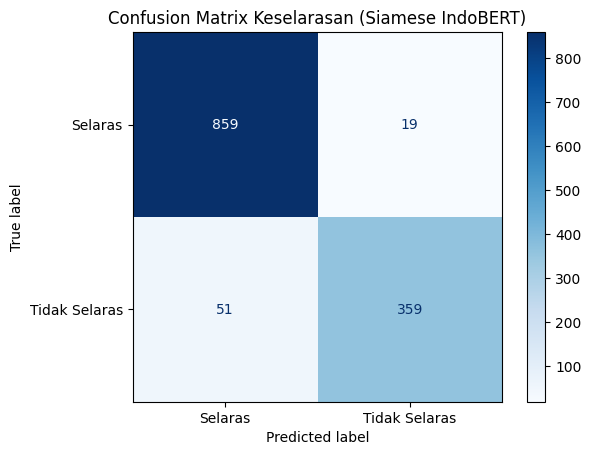

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = df["label"].map({
    1: "Selaras",
    0: "Tidak Selaras"
})

y_pred = df["pred_keselarasan"]

labels = ["Selaras", "Tidak Selaras"]

cm = confusion_matrix(y_true, y_pred, labels=labels)
print(classification_report(y_true, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_true, y_pred))

ConfusionMatrixDisplay(cm, display_labels=labels).plot(
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix Keselarasan (Siamese IndoBERT)")
plt.show()
